# Part 2 begins here

In [106]:
import math
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_probability as tfp

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Flatten, Conv2D, UpSampling2D, BatchNormalization, Reshape

tfb = tfp.bijectors
tfd = tfp.distributions
tfpl = tfp.layers

%matplotlib inline

In [107]:
# Set up plotting data

X, Y = np.meshgrid(np.linspace(-1, 1, 100), np.linspace(-1, 1, 100))
inputs = np.transpose(np.stack((X, Y)), [1, 2, 0])
print(inputs.shape)

(100, 100, 2)


In [108]:
# Helper function to compute transformed distribution densities

def get_densities(transformed_distribution):
    """
    This function takes a (batched) Distribution object as an argument, and returns a numpy 
    array Z of shape (batch_shape, 100, 100) of density values, that can be used to make a 
    contour plot with:
    plt.contourf(X, Y, Z[b, ...], cmap='hot', levels=100)
    where b is an index into the batch shape.
    """
    batch_shape = transformed_distribution.batch_shape
    Z = transformed_distribution.prob(np.expand_dims(inputs, 2))
    Z = np.transpose(Z, list(range(2, 2+len(batch_shape))) + [0, 1])
    return Z

In [109]:
# Helper function to convert contour plots to numpy arrays

import numpy as np
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
from matplotlib.figure import Figure

def get_image_array_from_density_values(Z):
    """
    This function takes a numpy array Z of density values of shape (100, 100)
    and returns an integer numpy array of shape (36, 36, 3) of pixel values for an image.
    """
    assert Z.shape == (100, 100)
    fig = Figure(figsize=(0.5, 0.5))
    canvas = FigureCanvas(fig)
    ax = fig.gca()
    ax.contourf(X, Y, Z, cmap='hot', levels=100)
    ax.axis('off')
    fig.tight_layout(pad=0)

    ax.margins(0)
    fig.canvas.draw()
    image_from_plot = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
    image_from_plot = image_from_plot.reshape(fig.canvas.get_width_height()[::-1] + (3,))
    return image_from_plot

In [110]:
def transform_distribution(distribution, alpha, theta):
    # treat alpha as a scale factor
    bijector = tfb.Scale(alpha)
    
    return tfd.TransformedDistribution(
        distribution,
        bijector
    )

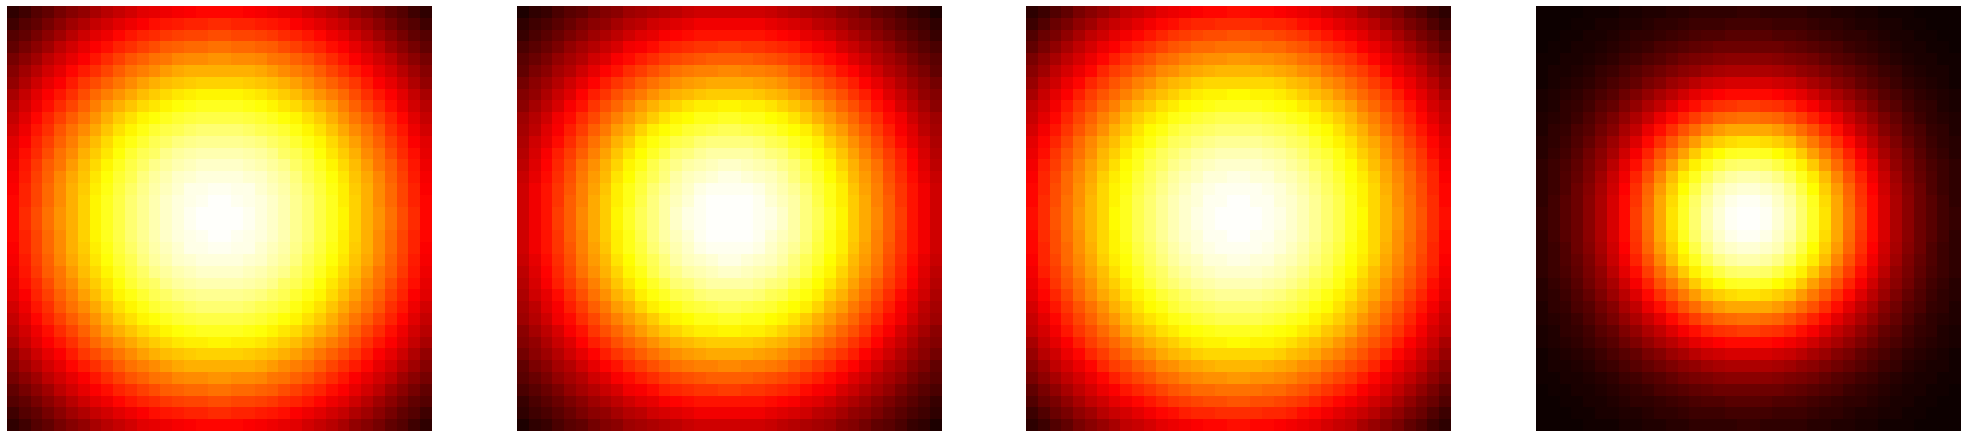

In [111]:
from IPython.display import Image, display

base_distribution = tfd.MultivariateNormalDiag(loc=[[0,0]], scale_diag=[[0.3,0.3]])

theta_distribution = tfd.Uniform(low=0.0, high=2*math.pi)
alpha_distribution = tfd.Normal(loc=0.0, scale=3.0)

fig, ax = plt.subplots(1, 4, figsize=(35, 35))

for i in range(4):
    alpha = alpha_distribution.sample()
    theta = theta_distribution.sample()
    transformed_distribution = transform_distribution(base_distribution, alpha, theta)
    
    densities = get_densities(transformed_distribution)
    density = densities[0]

    image = get_image_array_from_density_values(density)

    ax[i].imshow(image)
    ax[i].axis("off")
    
plt.show()

In [131]:
# Build the dataset
dataset_images = []
num_images = 300

for i in range(num_images):
    alpha = alpha_distribution.sample()
    theta = theta_distribution.sample()
    transformed_distribution = transform_distribution(base_distribution, alpha, theta)
    
    densities = get_densities(transformed_distribution)
    density = densities[0]

    image = get_image_array_from_density_values(density)
    
    dataset_images.append(image)

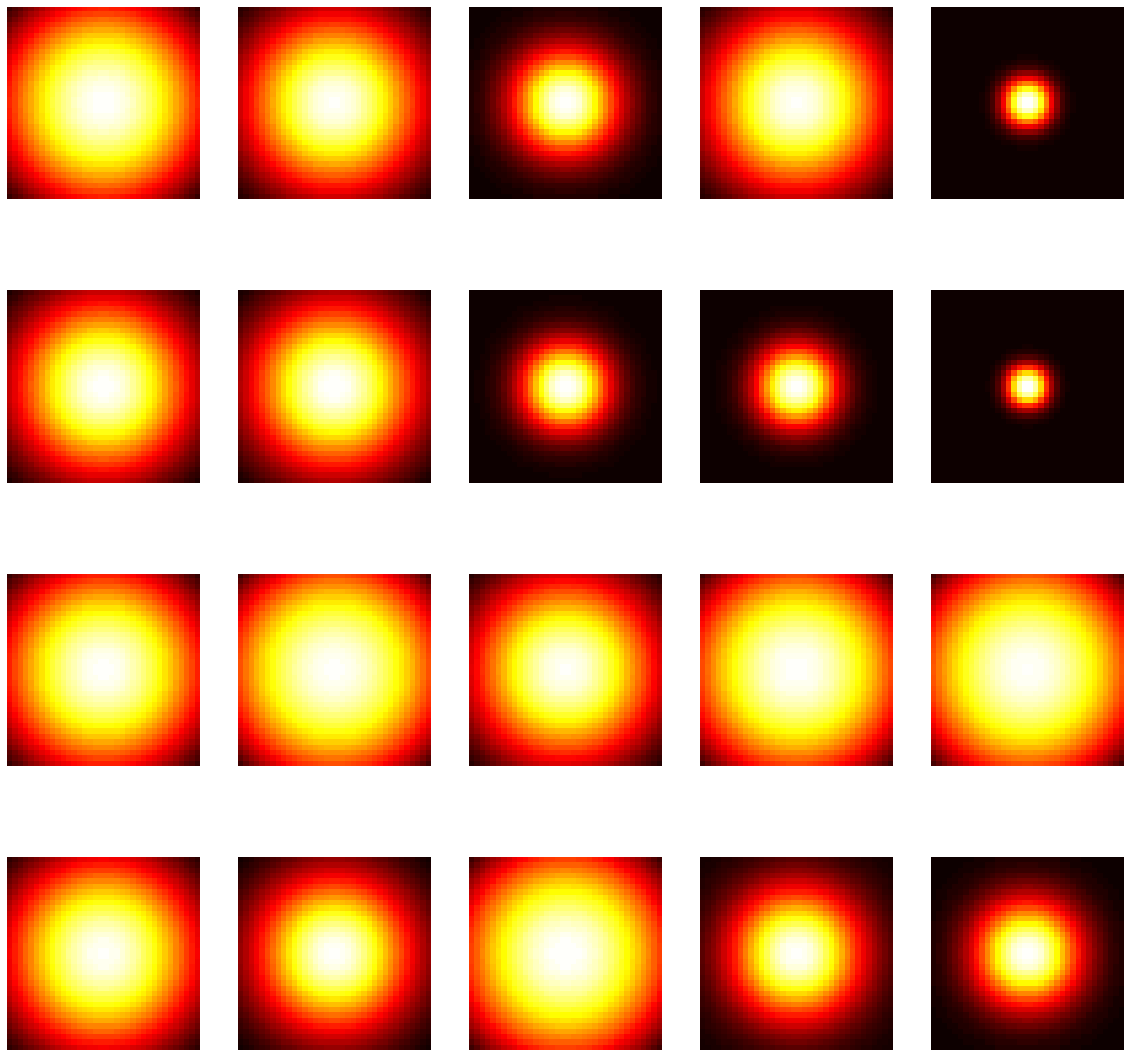

In [132]:
# Display a sample of 20 images from your generated dataset in a figure

from numpy.random import default_rng
rng = default_rng()

fig, axs = plt.subplots(4, 5, figsize=(20, 20))

for k in range(20):
    i = k // 5
    j = k % 5
    
    index = rng.integers(low=0, high=num_images)
    axs[i, j].imshow(dataset_images[index])
    axs[i, j].axis('off')
    
plt.show()

# Part 3 begins here

## 3. Make `tf.data.Dataset` objects
* You should now split your dataset to create `tf.data.Dataset` objects for training and validation data. 
* Using the `map` method, normalise the pixel values so that they lie between 0 and 1.
* These Datasets will be used to train a variational autoencoder (VAE). Use the `map` method to return a tuple of input and output Tensors where the image is duplicated as both input and output.
* Randomly shuffle the training Dataset.
* Batch both datasets with a batch size of 20, setting `drop_remainder=True`.
* Print the `element_spec` property for one of the Dataset objects.

In [133]:
dataset = tf.data.Dataset.from_tensor_slices(dataset_images)

train_size = int(0.80 * num_images)
validate_size = int(0.10 * num_images)
test_size = int(0.10 * num_images)

In [134]:
def normalize_image(image):
    normalized_image = tf.cast(image, tf.float32) / 255.
    return (normalized_image, normalized_image)

dataset = dataset.map(normalize_image)

train_dataset = dataset.take(train_size)
validate_dataset = dataset.skip(train_size).take(validate_size)
test_dataset = dataset.skip(train_size + validate_size)

In [135]:
train_dataset = train_dataset.shuffle(buffer_size=num_images)

In [136]:
train_dataset = train_dataset.batch(20, drop_remainder=True)
validate_dataset = validate_dataset.batch(20, drop_remainder=True)
test_dataset = test_dataset.batch(20, drop_remainder=True)

print(train_dataset.element_spec)

(TensorSpec(shape=(20, 36, 36, 3), dtype=tf.float32, name=None), TensorSpec(shape=(20, 36, 36, 3), dtype=tf.float32, name=None))


# Part four begins here

In [137]:
latent_dim = 50

prior = tfd.MultivariateNormalDiag(loc=tf.zeros(latent_dim))

In [138]:
def get_kl_regularizer(prior_distribution):
    """
    This function should create an instance of the KLDivergenceRegularizer 
    according to the above specification. 
    The function takes the prior_distribution, which should be used to define 
    the distribution.
    Your function should then return the KLDivergenceRegularizer instance.
    """
    return tfpl.KLDivergenceRegularizer(prior_distribution,
                                        weight=1.0,
                                        use_exact_kl=False,
                                        test_points_fn=lambda q: q.sample(3),
                                        test_points_reduce_axis=None) 

In [139]:
kl_regularizer = get_kl_regularizer(prior)

In [140]:
encoder = Sequential([
    Conv2D(filters=32, padding='SAME', kernel_size=(4,4), strides=(2,2), activation='relu', input_shape=(36,36,3)),
    BatchNormalization(),
    Conv2D(filters=64, padding='SAME', kernel_size=(4,4), strides=(2,2), activation='relu'),
    BatchNormalization(),
    Conv2D(filters=128, padding='SAME', kernel_size=(4,4), strides=(2,2), activation='relu'),
    BatchNormalization(),
    Conv2D(filters=256, padding='SAME', kernel_size=(4,4), strides=(2,2), activation='relu'),
    BatchNormalization(),
    Flatten(),
    Dense(tfpl.MultivariateNormalTriL.params_size(latent_dim)),
    tfpl.MultivariateNormalTriL(event_size=latent_dim, activity_regularizer=kl_regularizer)
])
encoder.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_28 (Conv2D)           (None, 18, 18, 32)        1568      
_________________________________________________________________
batch_normalization_16 (Batc (None, 18, 18, 32)        128       
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 9, 9, 64)          32832     
_________________________________________________________________
batch_normalization_17 (Batc (None, 9, 9, 64)          256       
_________________________________________________________________
conv2d_30 (Conv2D)           (None, 5, 5, 128)         131200    
_________________________________________________________________
batch_normalization_18 (Batc (None, 5, 5, 128)         512       
_________________________________________________________________
conv2d_31 (Conv2D)           (None, 3, 3, 256)        

In [141]:
for j, image in enumerate(train_dataset.take(2)):
    x = image[0]
    y = encoder(x)
    print(x.shape)
    print(y.shape)
    encoded = y
    
encoded.shape

(20, 36, 36, 3)
(20, 50)
(20, 36, 36, 3)
(20, 50)


TensorShape([20, 50])

In [142]:
decoder = Sequential([
    Dense(36*36, activation='relu', input_shape=(latent_dim,)),
    Reshape((9,9,16)),
    UpSampling2D(size=(2,2)),
    Conv2D(filters=128, padding='SAME', kernel_size=(3,3), activation='relu'),
    UpSampling2D(size=(2,2)),
    Conv2D(filters=128, padding='SAME', kernel_size=(3,3), activation='relu'),
    Conv2D(filters=3, padding='SAME', kernel_size=(3,3)),
    Flatten(),
    tfpl.IndependentBernoulli(event_shape=(36,36,3))
])
decoder.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 1296)              66096     
_________________________________________________________________
reshape_4 (Reshape)          (None, 9, 9, 16)          0         
_________________________________________________________________
up_sampling2d_8 (UpSampling2 (None, 18, 18, 16)        0         
_________________________________________________________________
conv2d_32 (Conv2D)           (None, 18, 18, 128)       18560     
_________________________________________________________________
up_sampling2d_9 (UpSampling2 (None, 36, 36, 128)       0         
_________________________________________________________________
conv2d_33 (Conv2D)           (None, 36, 36, 128)       147584    
_________________________________________________________________
conv2d_34 (Conv2D)           (None, 36, 36, 3)        

In [143]:
encoded

<tfp.distributions.MultivariateNormalTriL 'sequential_8_multivariate_normal_tri_l_4_MultivariateNormalTriL_MultivariateNormalTriL' batch_shape=[20] event_shape=[50] dtype=float32>

In [144]:
decoder(encoded)

<tfp.distributions.Independent 'sequential_9_independent_bernoulli_4_IndependentBernoulli_Independentsequential_9_independent_bernoulli_4_IndependentBernoulli_Bernoulli' batch_shape=[20] event_shape=[36, 36, 3] dtype=float32>

# Part five begins here

In [152]:
vae = Model(inputs=encoder.inputs, outputs=decoder(encoder.outputs))

In [153]:
def nll(batch_of_images, decoding_dist):
    return -tf.math.reduce_mean(decoding_dist.log_prob(batch_of_images), 0)

In [154]:
# Compile the model

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
vae.compile(optimizer=optimizer, loss=nll)

In [155]:
history = vae.fit(train_dataset, validation_data=validate_dataset, epochs=40, verbose=2)

Epoch 1/40
8/8 - 5s - loss: 965.9030 - val_loss: 1133.4213
Epoch 2/40
8/8 - 2s - loss: 923.4114 - val_loss: 884.1783
Epoch 3/40
8/8 - 2s - loss: 785.9030 - val_loss: 788.6520
Epoch 4/40
8/8 - 2s - loss: 703.7069 - val_loss: 694.8776
Epoch 5/40
8/8 - 2s - loss: 657.7633 - val_loss: 663.7031
Epoch 6/40
8/8 - 2s - loss: 630.0656 - val_loss: 641.6559
Epoch 7/40
8/8 - 2s - loss: 618.0189 - val_loss: 640.9741
Epoch 8/40
8/8 - 2s - loss: 615.6539 - val_loss: 635.6271
Epoch 9/40
8/8 - 2s - loss: 609.1159 - val_loss: 623.9246
Epoch 10/40
8/8 - 2s - loss: 610.4609 - val_loss: 631.4200
Epoch 11/40
8/8 - 3s - loss: 613.2913 - val_loss: 625.8615
Epoch 12/40
8/8 - 3s - loss: 614.7853 - val_loss: 632.4280
Epoch 13/40
8/8 - 2s - loss: 635.0746 - val_loss: 661.7737
Epoch 14/40
8/8 - 2s - loss: 647.1409 - val_loss: 651.4025
Epoch 15/40
8/8 - 2s - loss: 623.6385 - val_loss: 638.9349
Epoch 16/40
8/8 - 2s - loss: 613.0552 - val_loss: 621.9192
Epoch 17/40
8/8 - 2s - loss: 606.5991 - val_loss: 615.4242
Epoch

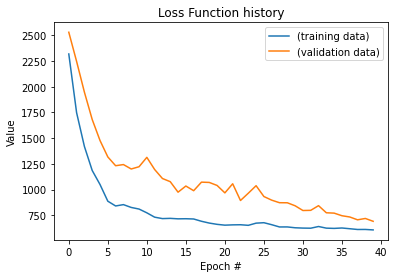

In [151]:
# Plot history:
plt.plot(history.history['loss'], label='Training data')
plt.plot(history.history['val_loss'], label='Validation data')
plt.title('Loss function history')
plt.ylabel('Value')
plt.xlabel('Epoch #')
plt.legend(loc="upper right")
plt.show()

# Part six begins here

129


AttributeError: 'tensorflow.python.framework.ops.EagerTensor' object has no attribute 'mean'

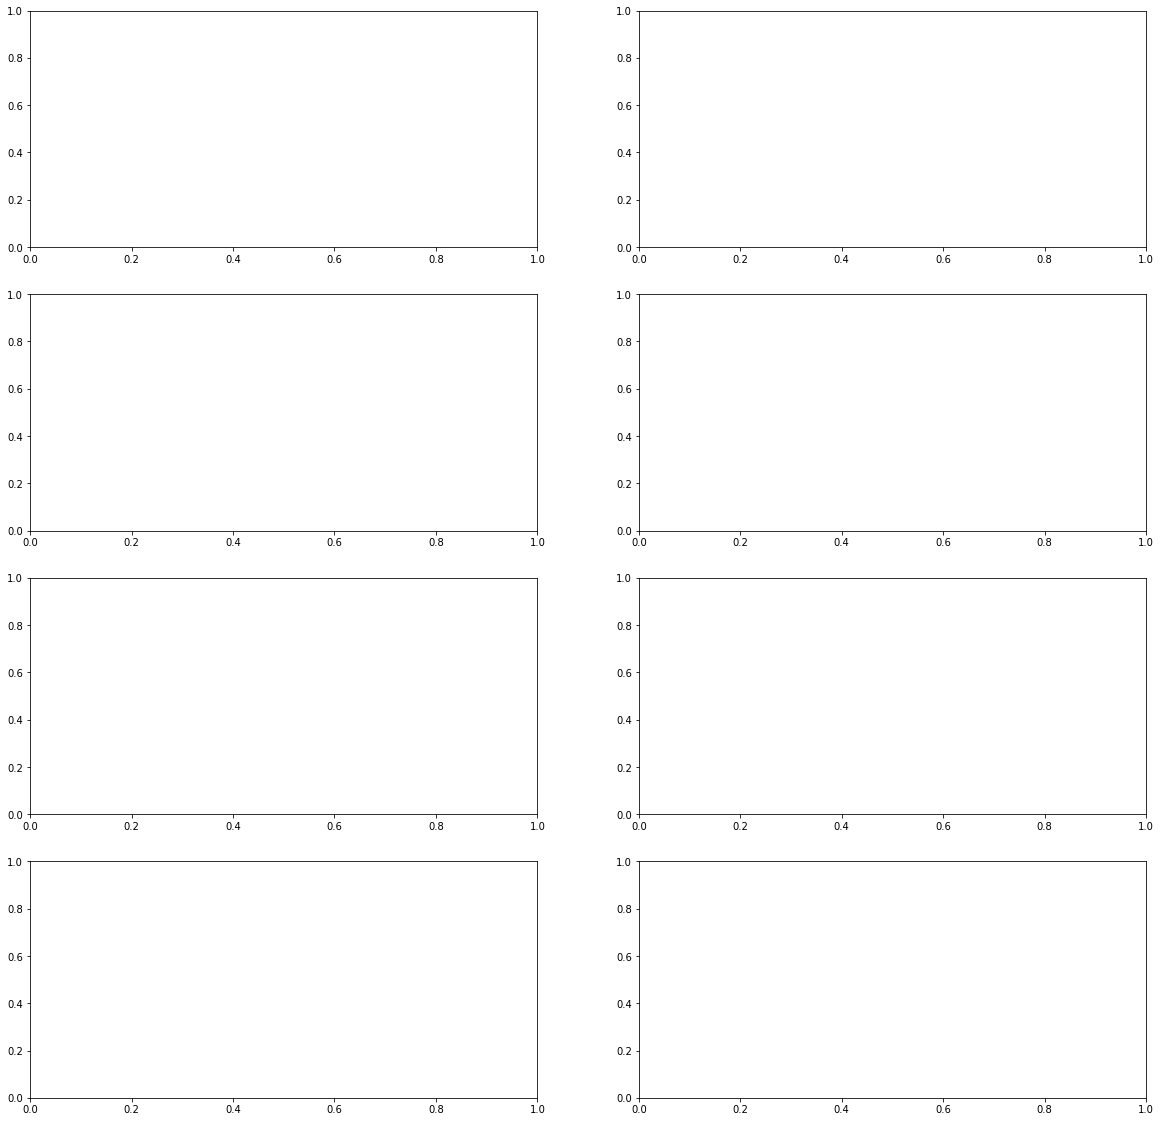

In [165]:
fig, axs = plt.subplots(4, 2, figsize=(20, 20))

for i in range(4):
    index = rng.integers(low=0, high=num_images)
    print(index)
    image = dataset_images[index]
    image_plus = tf.expand_dims(image, axis=0)
    normalized_image = tf.cast(image_plus, tf.float32) / 255.
    result = vae(normalized_image)
    print(result)
    
    axs[i, 0].imshow(image)
    axs[i, 0].axis('off')
    axs[i, 1].imshow(result)
    #axs[i, 1].axis('off')
    
plt.show()